Simplle GPT model written from scratch and trained in a corpus of Shakespeare text.

### Tokenizer

In [12]:
import re
class BPE_regex:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.merges_map = dict()
        self.vocabulary = {idx: bytes([idx]) for idx in range(256)}
        self.pat = r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| \d+| ?[^\s\w\d]+|\s+(?!\S)|\s+" # contractions, words, numbers, punctuation, continued spaces except 
        # the last space so it doesn't destroy the structure where a word or number starts with a space, and finally continued spaces at the end of the string 

    def decode(self, encoded):
        # Join the bytes as a string of bytes and then decode
        return b''.join([self.vocabulary[idx] for idx in encoded]).decode('utf-8', errors='replace')
    
    def encode(self, text):
        tokens = []
        for token in re.findall(self.pat, text, re.IGNORECASE):
            tokens.extend(tokenizer._encode(token))
        return tokens
    
    def _encode(self, text):
        # Transform string to a list of bytes
        encoded = list(text.encode('utf-8'))

        while len(encoded) > 1:
            # Find the pair that should be merged first: It is the pair that has the lowest id in the vocabulary
            pairs = set()
            for pair in zip(encoded[:-1], encoded[1:]):
                pairs.add(pair)
            pair_to_merge = min(pairs, key=lambda pair: self.merges_map.get(pair, float('inf'))) # The pair with the lowest index

            # If there is no pair to merge break out of the loop
            if pair_to_merge not in self.merges_map:
                break

            # Replace each merged token one by one in the merged order
            new_tokens = []
            i = 0
            while i < len(encoded):
                pair = encoded[i], encoded[i+1] if i < len(encoded) -1 else None # if is the last position pair is None
                # If there is pair to merge add the proper id and advance i to skip the tail of the pair
                if pair is not None and pair == pair_to_merge:
                    new_tokens.append(self.merges_map[pair_to_merge])
                    i += 1
                # If there is no pair to merge, add the id i in the ith position
                else:
                    new_tokens.append(encoded[i])
                # Go to the next id
                i += 1
            encoded = new_tokens

        return encoded

    def train(self, corpus):
        pre_tokens = re.findall(self.pat, corpus, re.IGNORECASE)
        new_encoded = [list(tok.encode('utf-8')) for tok in pre_tokens]

        vocab_size = 256 # initial vocab_size is the number of bytes
        while vocab_size < self.vocab_size:
            # Count pairs
            counts = {}
            for fragment in new_encoded:
                for pair in zip(fragment[:-1], fragment[1:]):
                    counts[pair] = counts.get(pair, 0) + 1
            # Get the pair to create the new token
            max_pair = max(counts, key=counts.get)

            # Save the new token
            new_tok_id = vocab_size
            self.vocabulary[new_tok_id] = self.vocabulary[max_pair[0]] + self.vocabulary[max_pair[1]] # Concatenate the bytes
            self.merges_map[max_pair] = new_tok_id
            vocab_size += 1

            # Check if there is any merging to do
            new_tokens = []
            for fragment in new_encoded:
                fragment_tokens = []
                i = 0
                while i < len(fragment):
                    pair = fragment[i], fragment[i+1] if i < len(fragment) -1 else None # if is the last position pair is None
                    if pair is not None and pair == max_pair:
                        fragment_tokens.append(new_tok_id)
                        i += 1
                    else:
                        fragment_tokens.append(fragment[i])
                    i += 1
                new_tokens.append(fragment_tokens)
            new_encoded = new_tokens


with open('shakespeare.txt') as file:
    corpus = file.read()
tokenizer = BPE_regex(2000)
tokenizer.train(corpus)

In [32]:
tokenizer.decode(tokenizer.encode(corpus)) == corpus

True

In [14]:
tokenizer.vocabulary

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

block_size = 128
emb_dim = 64
batch_size = 64
head_dim = 64
blocks_num = 4
heads_num = 4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
# Create the dataset
with open('shakespeare.txt') as file:
    content = file.read()

stoi = {s:i for i,s in tokenizer.vocabulary.items()}
print(len(tokenizer.vocabulary))

tokenized = torch.tensor(tokenizer.encode(content))
n = int(0.9*len(tokenized))
train_data = tokenized[:n]
val_data = tokenized[n:]
print(len(train_data), len(val_data))

2000
351411 39046


In [17]:
# Visualize the tokenization
[tokenizer.vocabulary[idx.item()] for idx in train_data[:100]]

[b'First',
 b' Citizen',
 b':',
 b'\n',
 b'Be',
 b'fore',
 b' we',
 b' pro',
 b'ceed',
 b' any',
 b' fur',
 b'ther',
 b',',
 b' hear',
 b' me',
 b' speak',
 b'.',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'Sp',
 b'eak',
 b',',
 b' speak',
 b'.',
 b'\n',
 b'\n',
 b'First',
 b' Citizen',
 b':',
 b'\n',
 b'You',
 b' are',
 b' all',
 b' res',
 b'ol',
 b'ved',
 b' rather',
 b' to',
 b' die',
 b' than',
 b' to',
 b' f',
 b'am',
 b'ish',
 b'?',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'R',
 b'es',
 b'ol',
 b'ved',
 b'.',
 b' res',
 b'ol',
 b'ved',
 b'.',
 b'\n',
 b'\n',
 b'First',
 b' Citizen',
 b':',
 b'\n',
 b'First',
 b',',
 b' you',
 b' know',
 b' C',
 b'a',
 b'ius',
 b' Marcius',
 b' is',
 b' chi',
 b'ef',
 b' enemy',
 b' to',
 b' the',
 b' people',
 b'.',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'We',
 b' know',
 b"'t",
 b',',
 b' we',
 b' know',
 b"'t",
 b'.',
 b'\n',
 b'\n',
 b'First']

In [18]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) # For every letter, the target is the letter to the right
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

x, y = get_batch('train')
x.shape, y.shape # Check how for each data element (64 features) there are 64 targets. Thats is because self-attention generates an output for each position (this can be used to make the prediction of the next token)

(torch.Size([64, 128]), torch.Size([64, 128]))

In [19]:
# Examples:
for i in range(8):
    print(f'\n\nEXAMPLE {i+1}:')
    for j in range(x.shape[1]):
        print(f'{tokenizer.decode(x[i,:j+1].cpu().numpy())} -> {tokenizer.decode([y[i,j].item()])}')



EXAMPLE 1:
 right -> :
 right: ->  but
 right: but ->  to
 right: but to ->  the
 right: but to the ->  point
 right: but to the point -> .
 right: but to the point. ->  
 right: but to the point.  -> As
 right: but to the point. As ->  I
 right: but to the point. As I ->  say
 right: but to the point. As I say -> ,
 right: but to the point. As I say, ->  this
 right: but to the point. As I say, this -> 

 right: but to the point. As I say, this
 -> M
 right: but to the point. As I say, this
M -> ist
 right: but to the point. As I say, this
Mist -> ress
 right: but to the point. As I say, this
Mistress ->  E
 right: but to the point. As I say, this
Mistress E -> l
 right: but to the point. As I say, this
Mistress El -> b
 right: but to the point. As I say, this
Mistress Elb -> ow
 right: but to the point. As I say, this
Mistress Elbow -> ,
 right: but to the point. As I say, this
Mistress Elbow, ->  being
 right: but to the point. As I say, this
Mistress Elbow, being -> ,
 right: but

In [27]:
class Head(nn.Module):
    def __init__(self,inp_dim, h_dim, block_size):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wk = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wv = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.tril = torch.tril(torch.ones(block_size, block_size, device=device))

    def forward(self, x):
        B, T, C = x.shape
        Q = x @ self.Wq
        K = x @ self.Wk
        V = x @ self.Wv
        attention = Q @ K.transpose(-2, -1) # [B,T,C]@[B,C,T] = [B,T,T]
        attention *= Q.shape[-1]**-0.5
        masked_attention = attention.masked_fill(self.tril[:T,:T] == 0, -torch.inf) # Mask future tokens. The [:T,:T] is to be able to work with inputs of less than T tokens, this is helpful for generation
        att_weights = F.softmax(masked_attention, dim=2) # Regularize the weights
        return att_weights @ V # [B,T,T]@[B,T,C] = [B,T,C] Make a weighted average of the vectors the possition attends to

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(input_dim, head_dim//num_heads, block_size) for _ in range(num_heads)])
        self.linear = nn.Linear(head_dim, input_dim)

    def forward(self, x):
        att = torch.cat([h(x) for h in self.heads], dim=-1)
        att = self.linear(att)
        return att
    
class Block(nn.Module):
    def __init__(self, num_heads, emb_dim, block_size):
        super().__init__()
        self.selfAttention = MultiHeadAttention(emb_dim, num_heads, block_size)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ffd = nn.Sequential(
            nn.Linear(emb_dim, 4*emb_dim), # scale up
            nn.ReLU(),
            nn.Linear(4*emb_dim, emb_dim) # scale down again for compatibility with the residual connections
        )
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        att = self.selfAttention(x)
        att = self.ln1(att + x)
        x = self.ffd(x)
        x = self.ln2(att + x)
        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(len(tokenizer.vocabulary), emb_dim)
        self.pos_emb = nn.Embedding(block_size, emb_dim)

        self.blocks = nn.Sequential(*[Block(heads_num, emb_dim, block_size) for _ in range(blocks_num)]) # Without the * it breaks

        self.final_dropout = nn.Dropout(0.4)

        self.final_proj = nn.Linear(head_dim, len(tokenizer.vocabulary))

    def forward(self, x, targets=None):
        emb1 = self.token_emb(x)
        # print(emb1.shape)
        emb2 = self.pos_emb(torch.arange(emb1.shape[1], device=device)) # Use emb.shape[1] instead of block_size because of inference. To being able to generate a prediction starting from 1 token with a max of block_size
        # print(emb2.shape)
        emb = emb1 + emb2
        # print(emb.shape)
        x = self.blocks(emb)

        x = self.final_dropout(x)
        # print(att.shape)
        logits = self.final_proj(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(batch_size*block_size, -1), targets.view(batch_size*block_size))
        return logits, loss

In [28]:
@torch.no_grad
def estimate_loss():
    model.eval()
    samples = 10
    # Estimate train loss
    losses = []
    for i in range(samples):
        x, y = get_batch('train')
        _, loss = model(x, y)
        losses.append(loss)
    print(f'Train loss: {sum(losses)/samples:.2f}', end='\t')
    # Estimate Validation loss
    losses = []
    for i in range(samples):
        x, y = get_batch('valid')
        _, loss = model(x, y)
        losses.append(loss)
    print(f'Val loss: {sum(losses)/samples:.2f}')
    model.train()

In [29]:
import math

steps = 100000
learning_rate = 1e-3
lossi = []

model = GPTModel()
model.train()
model = model.to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Baseline loss
print('baseline loss', -math.log(1/len(tokenizer.vocabulary)))

for i in range(steps):
    x, y = get_batch('train')
    logits, loss = model(x, y)
    if i % 10000 == 0:
        estimate_loss()
    
    # Update the weights
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Track stats
    lossi.append(loss.item())
loss.item()

0.46536 M parameters
baseline loss 7.600902459542082
Train loss: 7.76	Val loss: 7.78
Train loss: 3.35	Val loss: 4.06
Train loss: 3.18	Val loss: 4.13
Train loss: 3.08	Val loss: 4.34
Train loss: 2.97	Val loss: 4.46
Train loss: 2.90	Val loss: 4.55
Train loss: 2.86	Val loss: 4.71
Train loss: 2.82	Val loss: 4.73
Train loss: 2.75	Val loss: 4.88
Train loss: 2.73	Val loss: 4.94


3.0331032276153564

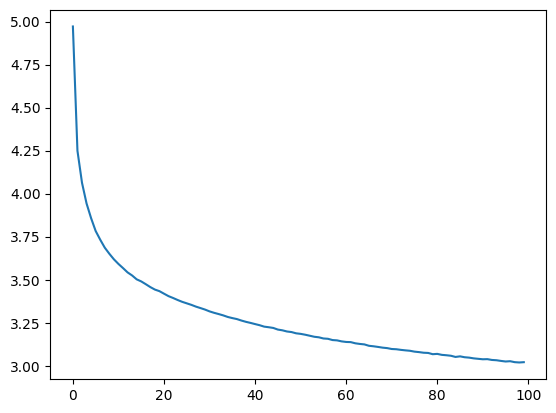

In [39]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [31]:
# Generation
model.eval()
@torch.no_grad
def generate(max_tokens=500):
    sample = torch.tensor([tokenizer.encode('\n')], device=device)
    while sample.shape[-1] < max_tokens:
        logits, loss = model(sample[:,:block_size])
        logits = logits[:,-1,:]
        # print(logits.shape)
        probs = F.softmax(logits, dim=-1)
        next_tok = torch.multinomial(probs, 1)
        sample = torch.cat((sample, next_tok), dim=-1)
    return tokenizer.decode(sample[0].cpu().numpy())

print(generate())


We marstity to hear my husband.

JULIET:
I pray you, poor soul: that is my sound;
And, to not?

ANGELO:
Death, how fares noble is the reconcial music.

LUCIO:
Then should I hold my pet by him all my breast,
And wortign thou liking on that locky,
Spirm, breasting stops, bound break, burding penen.

ISABELLA:
Why, if she dares gone to tell g set meet bed st t age deser c j pro give t cl t d be would cl make bra mo- bed see so ex will tell speak ne do king give talk get tell make death do res take cl make t pres proud keep- use help- ne gu speak d cons make d- part pro sister do prince man give ho- talk be hear mark che give give do sovereign pass see speak sub hold h be T death do bring part be st bl speak f uncle pr gre do son pass prison part su follow c sc heart  make h speak j h e t do cl be g tem mo say keep j come uncle t find nor be fear j cl- supp see bear keep come speak tell under bear play take Duke disp see bl make keep have  queen son do life sle br gu send t have keep k bl